# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


In [2]:
# обработка
import pandas as pd
import numpy as np
from scipy import stats
# визуализация
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# моделирование
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold


## Подготовка данных

In [3]:
train_backup, test_backup, full = (pd.read_csv('datasets/gold_recovery_train.csv', parse_dates=[0]),
                     pd.read_csv('datasets/gold_recovery_test.csv', parse_dates=[0]),
                     pd.read_csv('datasets/gold_recovery_full.csv', parse_dates=[0]))
train, test = train_backup.copy(), test_backup.copy()

Дату оставим в качестве индекса

In [4]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)
full.set_index('date', inplace=True)

In [5]:
train.shape

(16860, 86)

In [6]:
test.shape

(5856, 52)

In [7]:
full.shape

(22716, 86)

В тестовой выборке значительно меньше колонок, Выведем информацию по обучающей выборке, затем найдём колонки, которых нет в тестовой

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                     

Только один признак представлен в каждой из 16860 строк набора данных - *primary_cleaner.input.feed_size*, в остальных в том или ином объеме присутствуют пропуски

Колонки, отсутствующие в тестовой выборке:

In [9]:
test_train_difference = list(set(train.columns.values.tolist())-set(test.columns.values.tolist()))
test_train_difference

['rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.output.recovery',
 'rougher.output.concentrate_au',
 'final.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.tail_sol',
 'primary_cleaner.output.tail_pb',
 'final.output.concentrate_sol',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_sol',
 'final.output.recovery',
 'rougher.output.tail_ag',
 'final.output.tail_pb',
 'rougher.output.tail_au',
 'final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.concentrate_pb',
 'final.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_au',
 'final.output.concentrate_pb',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_

То есть, в тестовой выборке отсутствуют значения итоговых и промежуточных замеров и рассчётов. 
<br>Остаются показатели оборудования в процессе обработки и характеристики сырья на входе



## Проверка расчёта эффективности обогащения

Имеем формулу расчёта эффективности обогащения
$$
\\RECOVERY = \frac{C*(F-T)}{F*(C-T)}*100\% 
$$

Где:
- C — доля золота в концентрате после флотации/очистки; **rougher.output.concentrate_au**
- F — доля золота в сырье/концентрате до флотации/очистки; **rougher.input.feed_au**
- T — доля золота в отвальных хвостах после флотации/очистки. **rougher.output.tail_au**

Зададим соответствующую функцию:

In [10]:
def recovery_efficiency(C, F, T):
    recovery = 100*((C*(F-T))/(F*(C-T)))
    return recovery
    

Функцию необходимо проверить на обучающей выборке для признака rougher.output.recovery и найти MAE между расчётами и значением признака. 


Выведем отдельный набор данных с нужными признаками для тестирования формулы, для корректной работы функции *mean_absolute_error* избавимся от всех NaN-значений

In [11]:
train_interim = train[['rougher.output.concentrate_au',  'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']].dropna(axis = 0)

In [12]:
train_interim

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794
...,...,...,...,...
2018-08-18 06:59:59,18.603550,5.335862,0.748633,89.574376
2018-08-18 07:59:59,18.441436,4.838619,0.771582,87.724007
2018-08-18 08:59:59,15.111231,4.525061,0.685059,88.890579


In [13]:
train_interim['recovery_calculated'] = recovery_efficiency(C = train_interim['rougher.output.concentrate_au'],
                                                           F = train_interim['rougher.input.feed_au'],
                                                           T = train_interim['rougher.output.tail_au'])

In [14]:
train_interim.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,recovery_calculated
date,,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794,86.688794


In [15]:
mean_absolute_error(train_interim['rougher.output.recovery'], train_interim['recovery_calculated'])

9.303415616264301e-15

Значение крайне мало, и при взгляде на значения рассчитанного и имеющегося признаков видим полное совпадение при точности в 6 знаков после запятой. Можно сделать вывод о том, что эффективность обогащения рассчитана правильно


## Предоработка данных

Продублируем обучающую выборку без рассчётов и замеров, но оставим целевые признаки

In [16]:
train_columns = [column for column in train.columns if column not in test_train_difference]

In [17]:
train_columns.append('rougher.output.recovery')
train_columns.append('final.output.recovery')

In [18]:
train = train[train_columns]

В тестовый набор добавим целевые признаки, взятые из полного

In [19]:
test = test.join(full[['rougher.output.recovery', 'final.output.recovery']])

In [20]:
#проверка
display(test.loc['2016-09-01 01:59:59'][['final.output.recovery']])
display(full.loc['2016-09-01 01:59:59'][['final.output.recovery']])

final.output.recovery    68.910432
Name: 2016-09-01 01:59:59, dtype: float64

final.output.recovery    68.910432
Name: 2016-09-01 01:59:59, dtype: float64

Подробнее изучим пропуски в данных

In [21]:
def missing_values_percentage(df):
    count=round(df.isnull().sum(),2)
    percent=round((df.isnull().sum()/df.shape[0])*100,2)
    data=pd.concat([count,percent],axis=1)
    data.reset_index(inplace=True)
    data.rename(columns={0: 'Missing Values Count',1: 'Missing Values %'},inplace=True)
    display(data[data['Missing Values Count']!=0].sort_values(by = 'Missing Values %', ascending = False))

In [22]:
missing_values_percentage(train)

,index,Missing Values Count,Missing Values %
52,rougher.output.recovery,2573,15.26
21,rougher.input.floatbank11_xanthate,1904,11.29
53,final.output.recovery,1521,9.02
0,primary_cleaner.input.sulfate,1307,7.75
1,primary_cleaner.input.depressant,1262,7.49
18,rougher.input.floatbank10_sulfate,1044,6.19
3,primary_cleaner.input.xanthate,985,5.84
20,rougher.input.floatbank11_sulfate,623,3.70
30,rougher.state.floatbank10_e_air,603,3.58
14,rougher.input.feed_rate,513,3.04


К сожалению, информации о процессе и признаках не хватает для того, чтобы с полной уверенностью применять ту или иную стратегию заполнения.

Удалим пропуски, относящиеся к целевым признакам

In [23]:
train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], axis=0, inplace=True)
test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], axis=0, inplace=True)

In [24]:
missing_values_percentage(train)

,index,Missing Values Count,Missing Values %
30,rougher.state.floatbank10_e_air,436,3.08
21,rougher.input.floatbank11_xanthate,428,3.02
34,secondary_cleaner.state.floatbank2_a_air,217,1.53
15,rougher.input.feed_size,144,1.02
13,rougher.input.feed_pb,100,0.71
3,primary_cleaner.input.xanthate,100,0.71
16,rougher.input.feed_sol,78,0.55
20,rougher.input.floatbank11_sulfate,36,0.25
1,primary_cleaner.input.depressant,32,0.23
18,rougher.input.floatbank10_sulfate,29,0.20


In [25]:
missing_values_percentage(test)

,index,Missing Values Count,Missing Values %
21,rougher.input.floatbank11_xanthate,25,0.47
16,rougher.input.feed_sol,21,0.40
38,secondary_cleaner.state.floatbank3_a_air,9,0.17
20,rougher.input.floatbank11_sulfate,8,0.15
1,primary_cleaner.input.depressant,5,0.09
18,rougher.input.floatbank10_sulfate,5,0.09
0,primary_cleaner.input.sulfate,4,0.08
3,primary_cleaner.input.xanthate,4,0.08
14,rougher.input.feed_rate,3,0.06
34,secondary_cleaner.state.floatbank2_a_air,3,0.06


Взглянем на гистограммы и ящики с усами для имеющихся данных

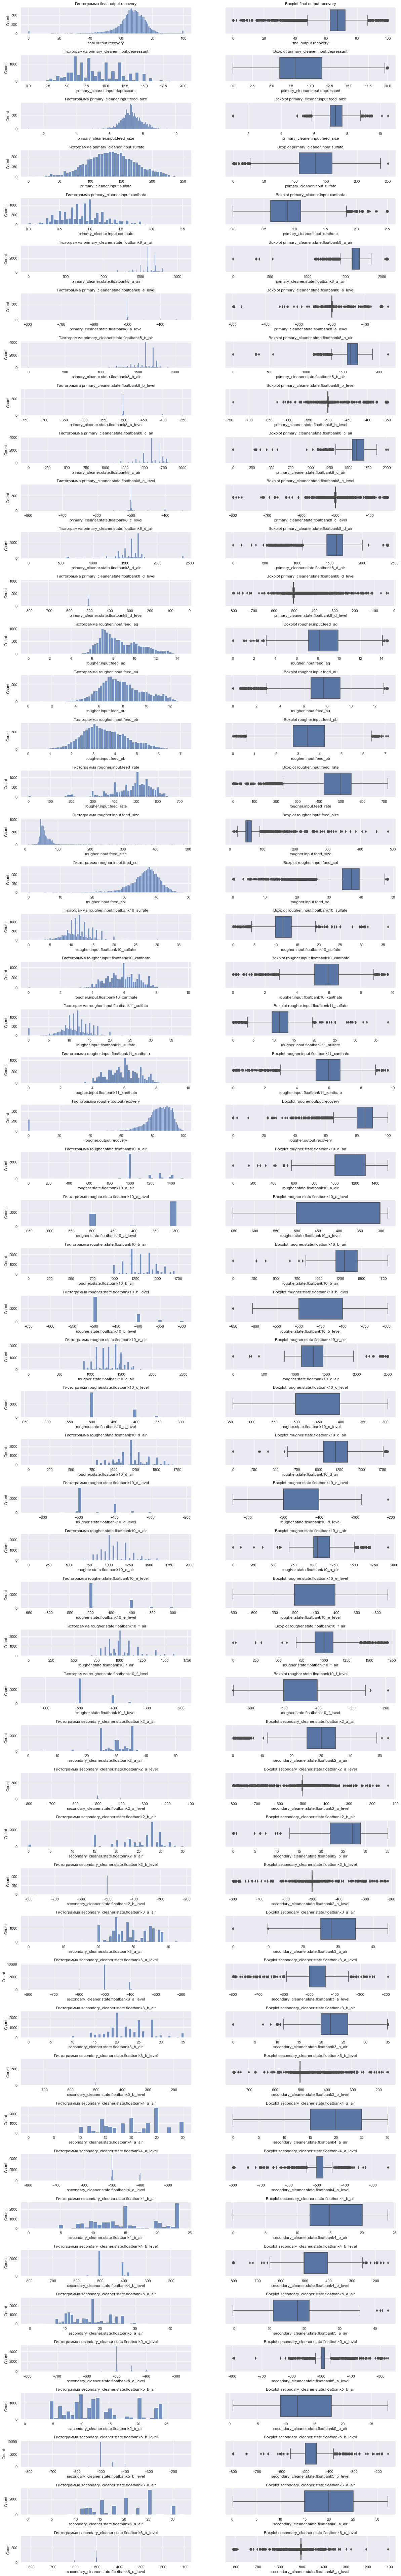

In [25]:
#выполняется долго
fig, axes = plt.subplots(nrows=54,ncols=2,  figsize=(20, 140))
fig.subplots_adjust(hspace = .8, wspace=.2)
i = 0
for col in train.columns.sort_values():
    sns.histplot(x = train[col], ax=axes[i][0]).set_title("Гистограмма " + col)
    sns.boxplot(x = train[col], ax=axes[i][1]).set_title("Boxplot " + col)
    i = i + 1

Показатели для *floatbank level* очень похожи между собой, основная доля значений плотно сгруппирована в районе -500, иногда добавляются группы поменьше. Нужно будет рассмотреть вариант с исключением из обучающей выборки части таких столбцов из-за мультиколлинеарности, оставить те, что больше всего взаимосвязаны с целевыми признаками

Примерно такая же картина, но с большей рассредоточенностью значений для *floatbank air* и добавок, добавляемых параллельно в несколько баков
для некоторых признаков, в том числе целевых, видим присутствие нулевых значений, стоящих особняком от остальных

In [26]:
train.eq(0).sum()

primary_cleaner.input.sulfate                   0
primary_cleaner.input.depressant               10
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                  0
primary_cleaner.state.floatbank8_a_air          0
primary_cleaner.state.floatbank8_a_level        0
primary_cleaner.state.floatbank8_b_air          0
primary_cleaner.state.floatbank8_b_level        0
primary_cleaner.state.floatbank8_c_air          0
primary_cleaner.state.floatbank8_c_level        0
primary_cleaner.state.floatbank8_d_air          0
primary_cleaner.state.floatbank8_d_level        0
rougher.input.feed_ag                           0
rougher.input.feed_pb                           0
rougher.input.feed_rate                         0
rougher.input.feed_size                         0
rougher.input.feed_sol                          0
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate               0
rougher.input.floatbank10_xanthate              0


In [27]:
train[train.eq(0)]=np.nan
train.dropna(axis=0, inplace=True)

In [28]:
test[test.eq(0)]=np.nan
test.dropna(axis=0, inplace=True)

In [29]:
test.shape

(5105, 54)

In [30]:
train.shape

(12417, 54)

От нулевых и отсутствующих значений избавились, оставшись с количеством строк, которого должно быть достаточно для обучения моделей.

## Анализ данных

### Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки.

Выделим нужные столбцы из имеющегося списка:

In [31]:
concentrate = {'Серебро':['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag' ],
               'Золото':['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au' ],
               'Свинец':['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb' ]}

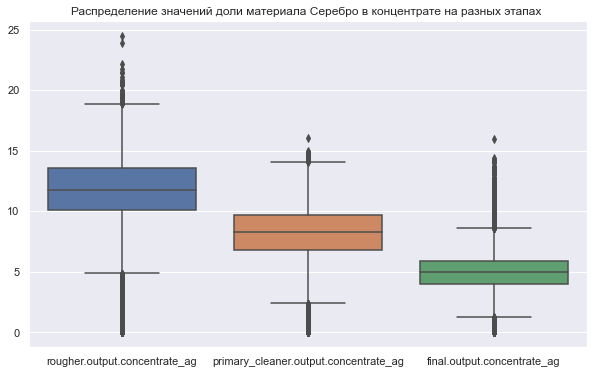

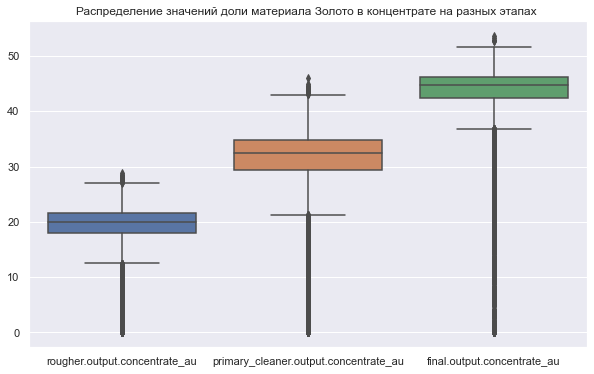

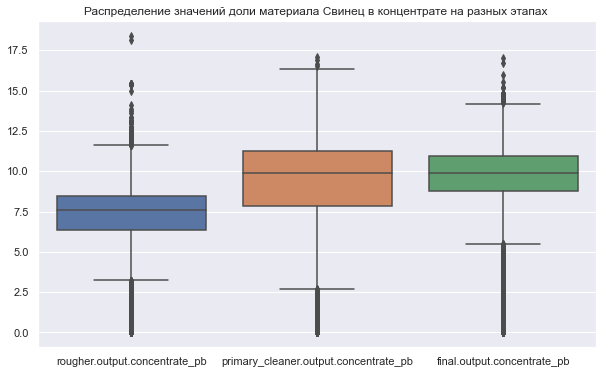

In [32]:
for key in concentrate:
    plt.figure(figsize=(10,6))
    sns.boxplot(data = full[concentrate[key]])
    plt.title(f'Распределение значений доли материала {key} в концентрате на разных этапах ')
    
    plt.show()

Во время очистки явно возрастает концентрация золота и падает концентрация серебра. Концентрация свинца вырастает после первичной очистки, но после вторичной изменений редко меняется

### Сравнения распределения размеров гранул сырья на обучающей и тестовой выборках.


Сравним графики выборочной функции распределения на двух выборках

In [35]:
temp = pd.concat([train['rougher.input.feed_size'].dropna(), test['rougher.input.feed_size'].dropna() ], axis = 1)
temp.columns = ['train', 'test']


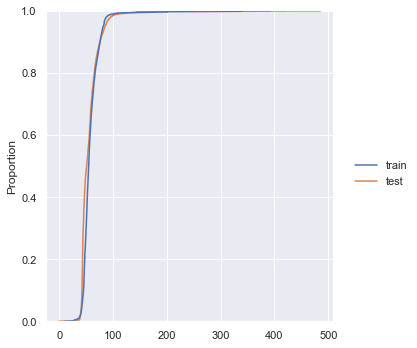

In [36]:
sns.displot(temp, kind = 'ecdf')
plt.show()

Графики почти совпадают, можно предположить, что отличия между распределениями размеров гранул сырья не существенны
Также посмотрим на основные статистические показатели

In [37]:
train[['rougher.input.feed_size']].dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_size,12417.0,58.538498,20.597407,9.659576,48.822217,54.796171,63.837292,484.967466


In [38]:
test[['rougher.input.feed_size']].dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_size,5105.0,55.917371,18.997593,0.046369,43.906347,51.033226,62.2813,392.49404


### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах на предмет аномалий


In [40]:
sum_concentrate = {'rougher':[x for x in full.columns if x.startswith('rougher.output.concentrate')],
               'primary_cleaner':[x for x in full.columns if x.startswith('primary_cleaner.output.concentrate')],
               'final':[x for x in full.columns if x.startswith('final.output.concentrate')]}

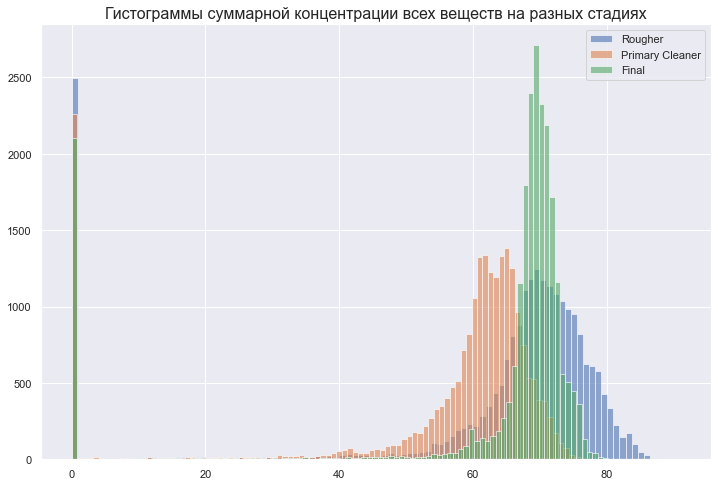

In [41]:
plt.figure(figsize=(12, 8))
for key in sum_concentrate:
    #sns.histplot(np.sum(train[sum_concentrate[key]], axis=1))
    np.sum(full[sum_concentrate[key]], axis=1).hist(bins = 100, alpha = 0.6 )
plt.title('Гистограммы суммарной концентрации всех веществ на разных стадиях', size = 16)
plt.legend(['Rougher', 'Primary Cleaner', 'Final'])
plt.show()   


Видим большое количество нулевых значений. Для суммарного показателя это вероятнее всего значит, что концентрат в принципе отсутствовал, то есть, прерывание процесса. 
Для предсказания результатов процесса следует оставить только данные для периодов, когда он шёл. Срежем нижние 10 процентов

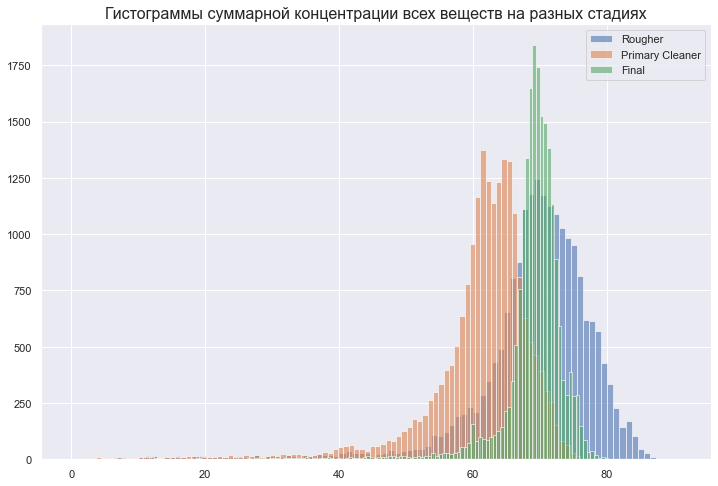

In [42]:
plt.figure(figsize=(12, 8))
for key in sum_concentrate:
    df = np.sum(full[sum_concentrate[key]], axis=1)
    cut_point = np.percentile(df, 10)
    df[df>cut_point].hist(bins = 100, alpha = 0.6 )
plt.title('Гистограммы суммарной концентрации всех веществ на разных стадиях', size = 16)
plt.legend(['Rougher', 'Primary Cleaner', 'Final'])
plt.show()   

In [43]:
train_backup[train_backup['rougher.output.concentrate_au']==0][['final.output.recovery']].shape[0]

1493

In [44]:
train_backup[train_backup['rougher.output.concentrate_au']==0][['final.output.recovery']].isna().sum()

final.output.recovery    1168
dtype: int64

Большая часть строк где значение доли вещества в черновом концентрате равно нулю, содержала NaN в целевом признаке и была удалена на этапе предобработки.

Видим, что на финальной стадии обработки диапазон значений заметно сужается

### Анализ мультиколлинеарности признаков

Визуально оценим общую картину на обучающей выборке

<AxesSubplot:>

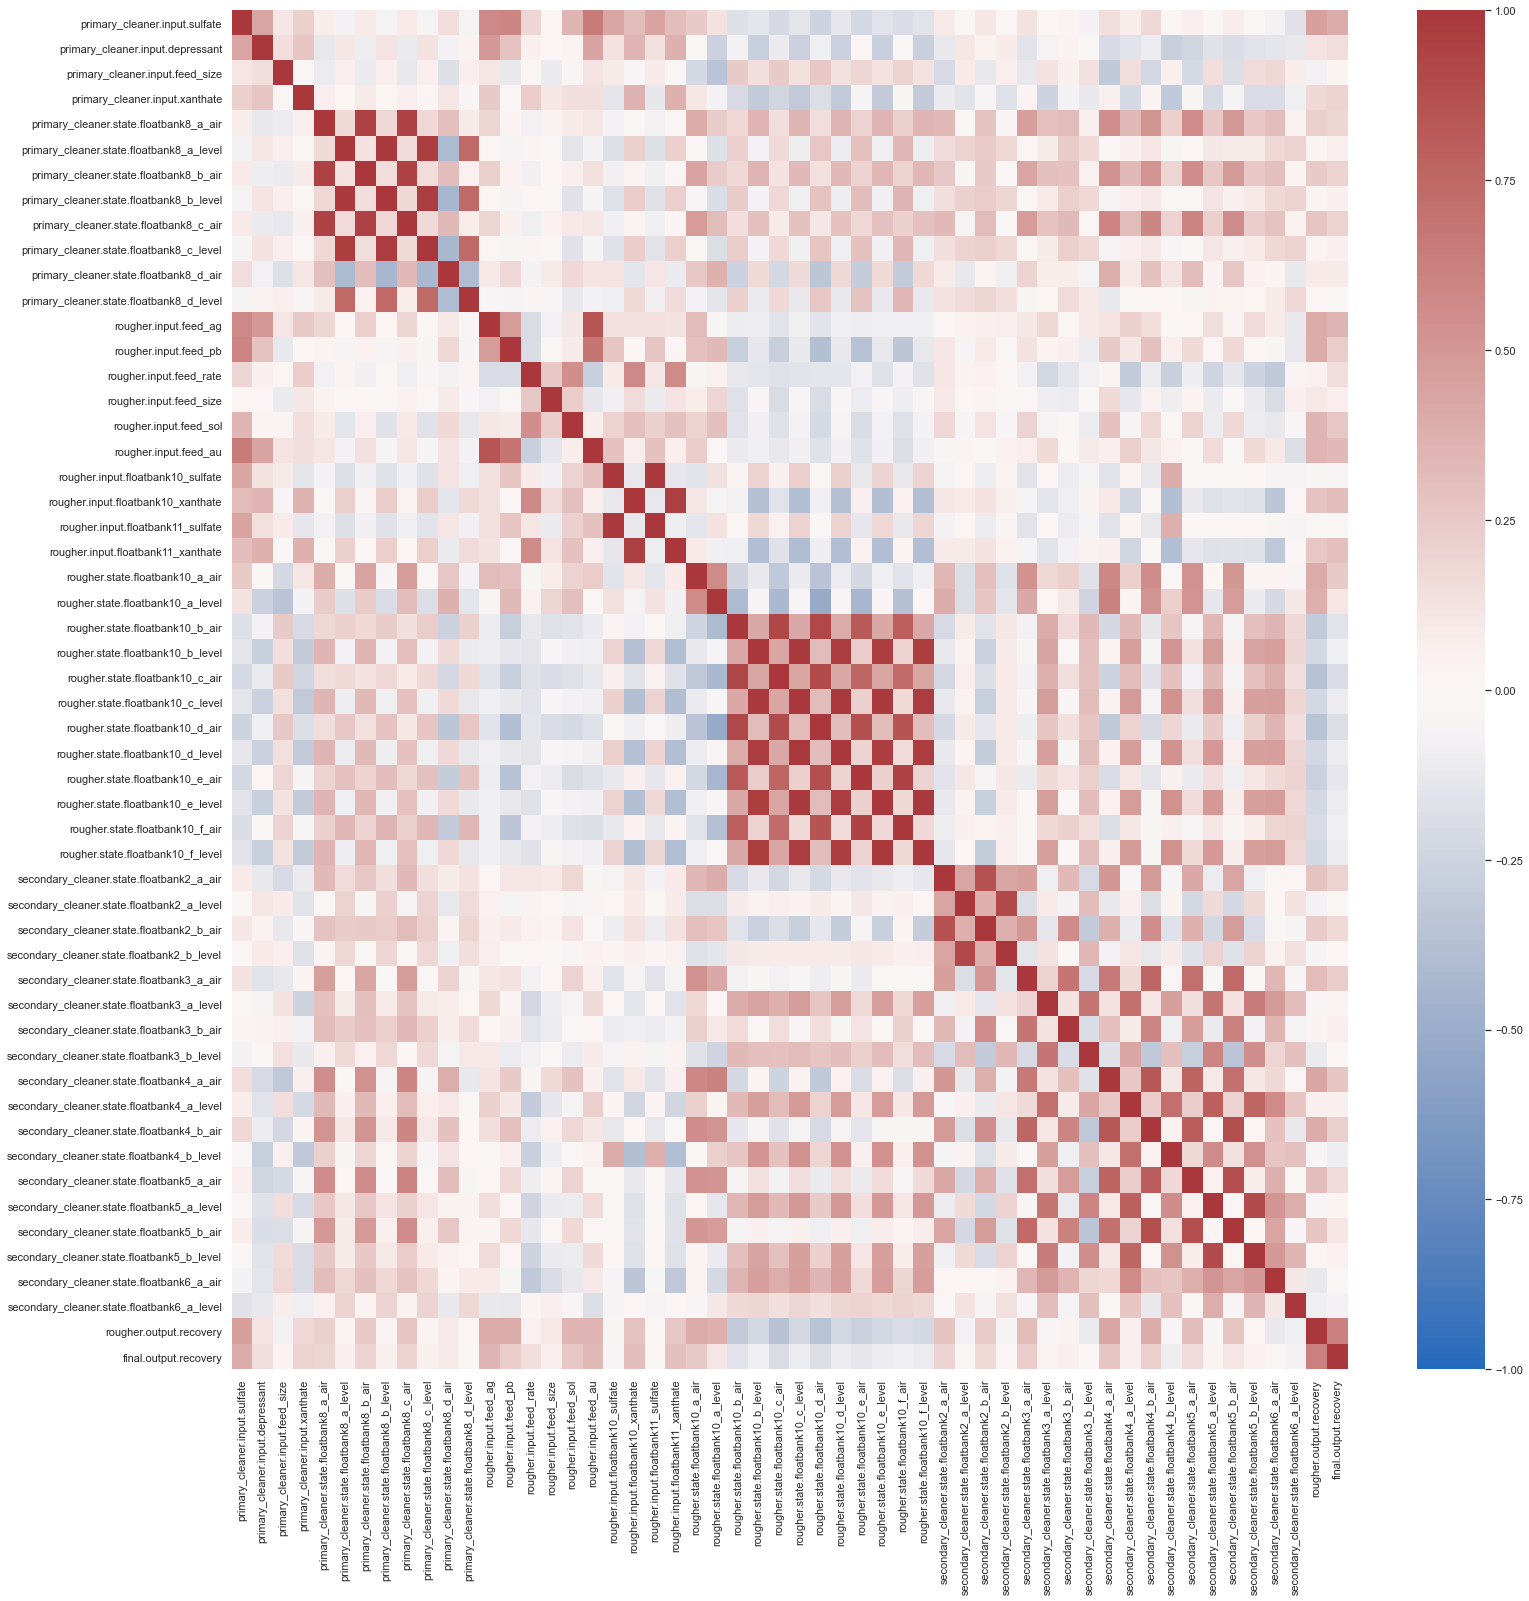

In [42]:
plt.figure(figsize=(25, 25))
sns.heatmap(train.corr(), vmin = -1, vmax = 1, cmap = 'vlag')

Показатели floatbank сильно коррелируют между собой, при формировании входных признаков для моделей оставим те, что имеют наибольшую взаимосвязь с целевыми признаками и удалим остальные

## Модель

В качестве метрики качества имеем sMAPE
$$
\\sMAPE = \frac{1}{N}\sum_{i=1}^{N}*\frac{|y_{i}-\hat{y}|}{(|y_{i}|+|\hat{y}|)/2}*100\% 
$$

И итог нам нужно оценивать как **25% \* sMAPE(rougher) + 75% \* sMAPE(final)**

Создадим функцию для вычисления

In [45]:
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

In [46]:
smape_scoring = make_scorer(smape, greater_is_better=False)

In [47]:
def smape_final(rough, final):
    return 0.25*rough+0.75*final

### Формирование признаков

Для предсказания эффективности обогащения после первого этапа, будем использовать показатели относящиеся к только к нему

In [48]:
rougher_features = []
for column in train.columns:
    if ("rougher" in column):
        rougher_features.append(column)

<AxesSubplot:>

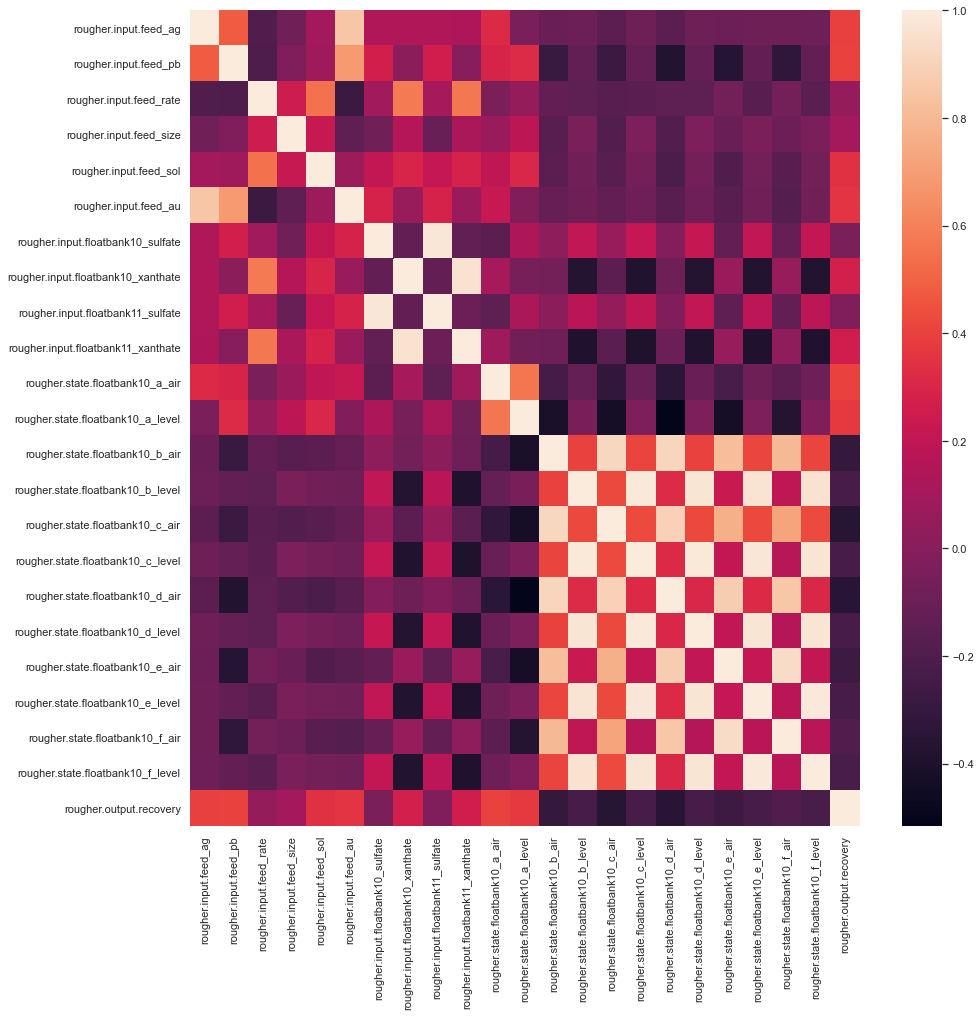

In [49]:
plt.figure(figsize=(15, 15))
sns.heatmap(train[rougher_features].corr())

In [50]:
rougher_features = ['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level']

In [51]:
final_features = []
for column in train.columns:
    if not("rougher" in column):
        final_features.append(column)

<AxesSubplot:>

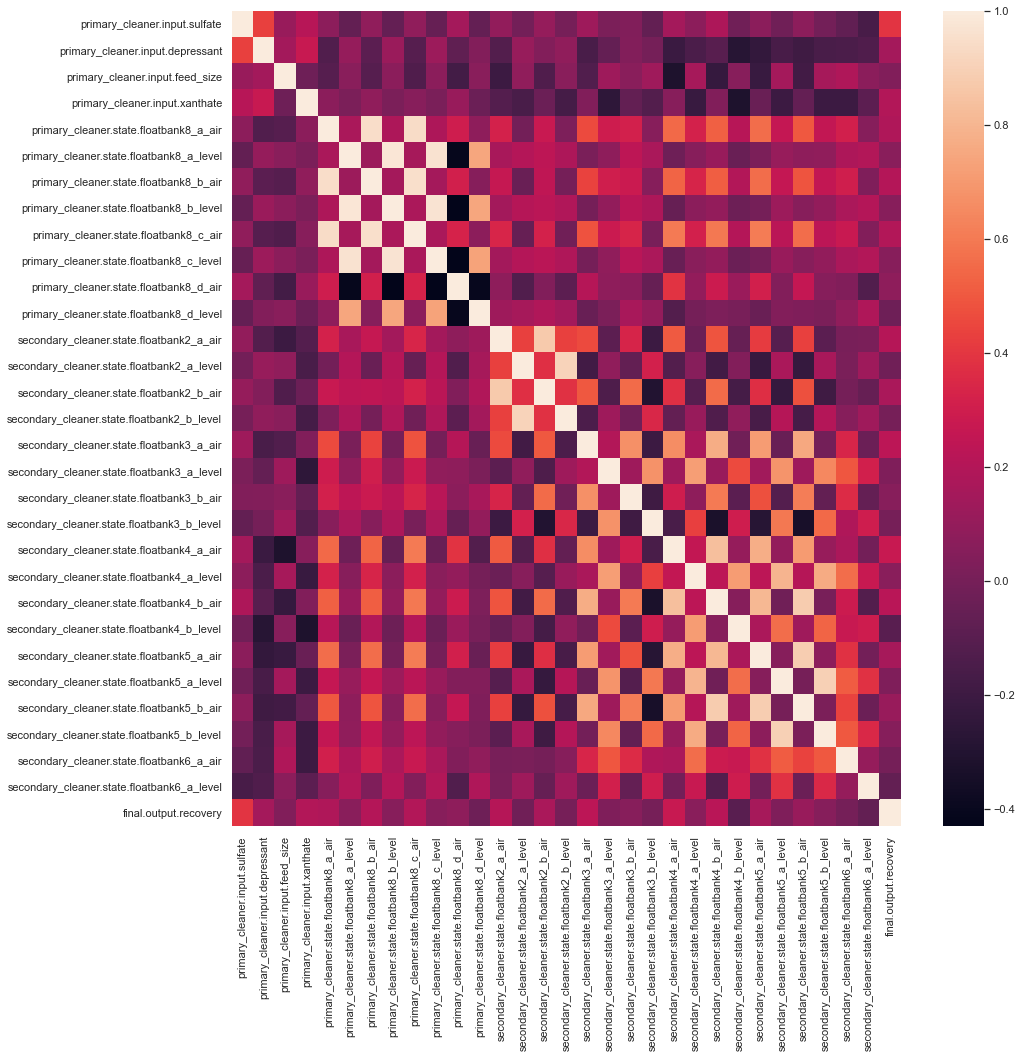

In [52]:
plt.figure(figsize=(15, 15))
sns.heatmap(train[final_features].corr())

In [53]:
final_features = ['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'secondary_cleaner.state.floatbank4_a_air',
 'secondary_cleaner.state.floatbank4_a_level'
]

In [54]:

X_train_rougher = train[rougher_features]
Y_train_rougher = train['rougher.output.recovery']
X_test_rougher = test[rougher_features]
Y_test_rougher = test['rougher.output.recovery']

display(X_train_rougher.shape)
display(Y_train_rougher.shape)
display(X_test_rougher.shape)
display(Y_test_rougher.shape)


#X_train_final = train.drop(columns=['final.output.recovery', 'rougher.output.recovery'])
X_train_final = train[final_features+rougher_features]
Y_train_final = train['final.output.recovery']
#X_test_final = test.drop(columns=['final.output.recovery', 'rougher.output.recovery'])
X_test_final = test[final_features+rougher_features]
Y_test_final = test['final.output.recovery']

display(X_train_final.shape)
display(Y_train_final.shape)
display(X_test_final.shape)
display(Y_test_final.shape)

(12417, 10)

(12417,)

(5105, 10)

(5105,)

(12417, 18)

(12417,)

(5105, 18)

(5105,)

### Константная модель

Для последующей проверки на адекватность вычислим sMAPE для константной модели

In [55]:
dummy_regr = DummyRegressor(strategy='median')
dummy_regr_2 = DummyRegressor(strategy='median')
dummy_regr.fit(X_train_rougher, Y_train_rougher)
dummy_regr_2.fit(X_train_final, Y_train_final)
Dummy_predictions = dummy_regr.predict(X_test_rougher)
Dummy_predictions_2 = dummy_regr_2.predict(X_test_final)
rough = smape(Y_test_rougher, Dummy_predictions) 
final = smape(Y_test_final, Dummy_predictions_2)
dummy_final = smape_final(rough, final)
dummy_final

7.286852313677384

### Сравнение моделей с применением кроссвалидации

In [56]:
pipelines = []
rand = 1
pipelines.append(('Linear Regression' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('LR' ,LinearRegression())]))))
pipelines.append(('Random Forest Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('RFR' ,RandomForestRegressor(random_state=rand))]))))
pipelines.append(('Decision Tree Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('DT' ,DecisionTreeRegressor(random_state=rand))]))))
pipelines.append(('Support Vector Regressor' ,
                  (Pipeline([('scaled' , MinMaxScaler()),
                             ('SVR' , SVR())]))))
pipelines.append(('KNN Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('KNN', KNeighborsRegressor(n_neighbors=50))]))))
pipelines.append(('Lasso Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('Lasso', Lasso(random_state=rand))]))))
pipelines.append(('Ridge Regressor',
                  (Pipeline([('scaled', MinMaxScaler()),
                             ('Ridge', Ridge(random_state=rand))]))))

model_name = []
results = []
for pipe, model in pipelines:
    kfold = KFold(n_splits=3, shuffle= True)
    crossv_results_rougher = cross_val_score(model , X_train_rougher ,Y_train_rougher ,cv = kfold , scoring=smape_scoring)
    crossv_results_final = cross_val_score(model , X_train_final ,Y_train_final ,cv = kfold , scoring=smape_scoring)
    results.append(abs(smape_final(crossv_results_rougher, crossv_results_final)))
    model_name.append(pipe)
    msg = "%s: %f (%f)" % (pipe, np.mean(results[-1]), np.std(results[-1]))
    print(msg)

Linear Regression: 7.151107 (0.098941)
Random Forest Regressor: 4.804202 (0.054531)
Decision Tree Regressor: 6.935772 (0.029260)
Support Vector Regressor: 6.220975 (0.104193)
KNN Regressor: 5.813544 (0.171686)
Lasso Regressor: 8.930379 (0.054113)
Ridge Regressor: 7.152391 (0.073170)


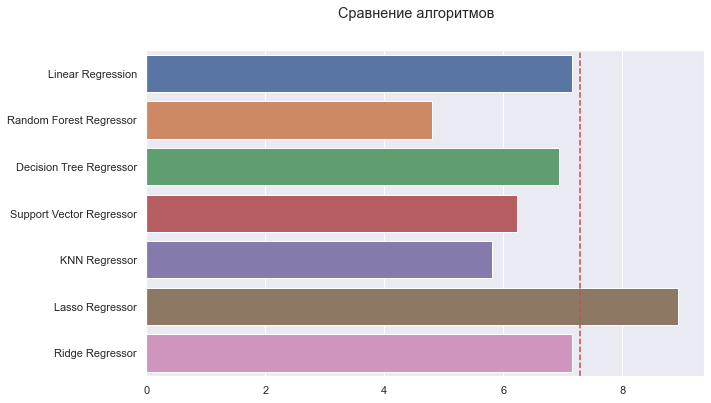

In [57]:
# сравнение алгоритмов
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
sns.barplot(x = np.mean(results, axis = 1), y = model_name)

plt.axvline(dummy_final, color = 'r', linestyle = '--')
plt.show()

Лучше всего себя показывает Random Forest Regressor, при условии перемешивания данных. 

При параметре Shuffle = False, ни одна из моделей не показала результат лучше DummyRegressor

### Проверка на тестовой выборке

Перемешиваем признаки

In [58]:
X_train_rougher_shuffled = shuffle(X_train_rougher, random_state = 1)
X_test_rougher_shuffled = shuffle(X_test_rougher, random_state = 1)
Y_train_rougher_shuffled = shuffle(Y_train_rougher, random_state = 1)
Y_test_rougher_shuffled = shuffle(Y_test_rougher, random_state = 1)
X_train_final_shuffled = shuffle(X_train_final, random_state = 1)
X_test_final_shuffled = shuffle(X_test_final, random_state = 1)
Y_train_final_shuffled = shuffle(Y_train_final, random_state = 1)
Y_test_final_shuffled = shuffle(Y_test_final, random_state = 1)

In [59]:
pipe = Pipeline([('scaled', MinMaxScaler()), ('RFR', RandomForestRegressor(random_state=rand))])
pipe.fit(X_train_rougher_shuffled, Y_train_rougher_shuffled)
pred_rougher = pipe.predict(X_test_rougher_shuffled)
rougher = smape(Y_test_rougher_shuffled, pred_rougher)

In [60]:
pipe_final = Pipeline([('scaled', MinMaxScaler()), ('RFR', RandomForestRegressor(random_state=rand))])
pipe_final.fit(X_train_final_shuffled, Y_train_final_shuffled)
pred_final = pipe_final.predict(X_test_final_shuffled)
final = smape(Y_test_final_shuffled, pred_final)

In [61]:
smape_final(rougher, final)

7.03858579968355

Результат на тестовой выборке незначительно лучше, чем на константной модели
Проверим также модель, которая показала второй лучший результат - KNN Regressor

In [62]:
pipe_KNN = Pipeline([('scaled', MinMaxScaler()), ('KNN', KNeighborsRegressor(n_neighbors=50))])
pipe_KNN.fit(X_train_rougher_shuffled, Y_train_rougher_shuffled)
pred_rougher = pipe_KNN.predict(X_test_rougher_shuffled)
rougher = smape(Y_test_rougher_shuffled, pred_rougher)

In [63]:
pipe_KNN_final = Pipeline([('scaled', MinMaxScaler()), ('KNN', KNeighborsRegressor(n_neighbors=50))])
pipe_KNN_final.fit(X_train_final_shuffled, Y_train_final_shuffled)
pred_final = pipe_KNN_final.predict(X_test_final_shuffled)
final = smape(Y_test_final_shuffled, pred_final)

In [64]:
smape_final(rougher, final)

6.261965911825796

В данном случае результат также лучше, чем на константной модели и просадка по качеству не такая сильная.

## Вывод

- Имеющиеся данные были обработаны, удалены пропуски и нулевые значения, при этом осталось достаточное количество данных для работы
- Проанализирована концентрация металлов в растворе по отдельности и суммарно на разных этапах обогащения
- Найдена мультиколлинеарность между признаками, на этапе подготовки входных данных для моделей лишние признаки были отброшены, что заметно сказалось на качестве (итерации остались "за кадром")
- было проведено сравнение нескольких алгоритмов регрессии, доступных в библиотеке sklearn. Почти все алогритмы на кроссвалидации показали результаты лучше, чем константная модель. 
<br>Для итоговой проверки выбраны RandomForest Regressor и KNN Regressor.
- на тестовой выборке KNN показывает лучший результат, а так же обучается заметно быстрее, поэтому рекомендован для дальнейшего использования